<a href="https://colab.research.google.com/github/Grashch/Data-science/blob/main/TreeRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Подключаем необходимые библиотеки для работы с данными и моделями машинного обучения
import numpy as np              # Библиотека для работы с массивами и матричными операциями
import pandas as pd             # Библиотека для работы с табличными данными
from sklearn.preprocessing import OneHotEncoder      # Класс для one-hot кодирования категориальных признаков
from sklearn.model_selection import train_test_split  # Метод для разделения данных на обучающие и тестовые наборы
from sklearn.model_selection import GridSearchCV      # Кросс-валидация для выбора лучших гиперпараметров модели
from sklearn.tree import DecisionTreeRegressor        # Реализация дерева решений для регрессии
from sklearn.tree import plot_tree                   # Инструмент для визуализации деревьев решений
from sklearn.metrics import mean_squared_error       # Метрика среднеквадратичной ошибки
from sklearn.metrics import mean_absolute_error      # Метрика средней абсолютной ошибки

In [46]:
# Загрузка данных из CSV-файла
# Данные содержат информацию о шоколаде: производителях, происхождении какао-бобов, проценте какао и оценках
data = pd.read_csv('/content/flavors_of_cacao.csv')

# Переименование столбцов для удобства работы
# Исходные названия содержали спецсимволы и переносы строк, что затрудняло обращение к ним
data = data.rename(columns={
    'Company\xa0\n(Maker-if known)': 'Company (Maker-if known)',
    'Specific Bean Origin\nor Bar Name': 'Specific Bean Origin or Bar Name',
    'Review\nDate': 'Review Date',
    'Cocoa\nPercent': 'Cocoa Percent',
    'Company\nLocation': 'Company Location',
    'Bean\nType': 'Bean Type',
    'Broad Bean\nOrigin': 'Broad Bean Origin'
})

# Преобразование столбца 'Cocoa Percent' в числовой формат
# Удаляем символ процента и преобразуем значения в числа с плавающей точкой
data['Cocoa Percent'] = data['Cocoa Percent'].str.replace('%', '').astype(float)

# Выводим первые 5 строк данных для проверки корректности загрузки и преобразований
data.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,,Peru


In [48]:
# Проверяем долю пропущенных значений (NaN) в каждом столбце
# Это помогает понять, какие столбцы требуют дополнительной обработки
data.isna().mean(axis=0)

,0
Company (Maker-if known),0.000000
Specific Bean Origin or Bar Name,0.000000
REF,0.000000
Review Date,0.000000
Cocoa Percent,0.000000
Company Location,0.000000
Rating,0.000000
Bean Type,0.000557
Broad Bean Origin,0.000557


In [57]:
# Создаем списки для категориальных и числовых признаков
# Категориальные признаки — это текстовые значения (названия компаний, стран и т.д.)
# Числовые признаки — это числа (процент какао, дата отзыва и т.д.)
categorical_features = []
numerical_features = []

# Определяем категориальные признаки по типу данных 'object' (обычно строки)
categorical_columns = [col for col in data.columns if data[col].dtype == "object"]

In [50]:
# Подсчитываем частоту встречаемости значений в столбце 'Company (Maker-if known)'
# Это поможет выделить крупные компании (с большим числом записей) от мелких
company_stat = data['Company (Maker-if known)'].value_counts()
company_stat

,count
Company (Maker-if known),
Soma,47
Bonnat,27
Fresco,26
Pralus,25
A. Morin,23
...,...
Svenska Kakaobolaget,1
Baravelli's,1
Urzi,1


In [51]:
# Создаем новый столбец 'company', где:
# - если компания встречается ≥18 раз — оставляем её название
# - иначе — объединяем в категорию 'Other' (другие)
data['company'] = data['Company (Maker-if known)'].apply(
    lambda x: x if company_stat[x] >= 18 else 'Other'
)

# Выводим распределение значений в новом столбце
data['company'].value_counts()

,count
company,
Other,1505
Soma,47
Bonnat,27
Fresco,26
Pralus,25
A. Morin,23
Arete,22
Guittard,22
Domori,22


In [59]:
# Аналогично обрабатываем другие категориальные столбцы:
# 'Specific Bean Origin or Bar Name' → 'origin'
# 'Company Location' → 'location'
# 'Bean Type' → 'bean_type'
# 'Broad Bean Origin' → 'bean_origin'
origin_stat = data['Specific Bean Origin or Bar Name'].value_counts()
location_stat = data['Company Location'].value_counts()
type_stat = data['Bean Type'].value_counts(dropna=False)
bean_stat = data['Broad Bean Origin'].value_counts(dropna=False)

data['origin'] = data['Specific Bean Origin or Bar Name'].apply(
    lambda x: x if origin_stat[x] >= 18 else 'Other'
)
data['location'] = data['Company Location'].apply(
    lambda x: x if location_stat[x] >= 18 else 'Other'
)
data['bean_type'] = data['Bean Type'].apply(
    lambda x: x if type_stat[x] >= 20 else 'Other'
)
data['bean_origin'] = data['Broad Bean Origin'].apply(
    lambda x: x if bean_stat[x] >= 18 else 'Other'
)

In [60]:
# Добавляем новые категориальные признаки в список
categorical_features.extend(['company', 'origin', 'location', 'bean_type', 'bean_origin'])

# Добавляем числовые признаки в список
numerical_features.extend(['REF', 'Review Date', 'Cocoa Percent'])

In [61]:
# Вычисляем суммарное число уникальных категорий во всех категориальных признаках
# Это полезно для понимания размерности данных после кодирования
sum([data[feature].nunique() for feature in categorical_features])

70

In [62]:
# Применяем One-Hot Encoding для категориальных признаков
# Это преобразование превращает категории в бинарные столбцы (0 или 1)
encoder = OneHotEncoder()
encoder.fit(data[categorical_features])

OneHotEncoder()

In [63]:
# Формируем названия новых столбцов после кодирования
# Например, 'company:Lindt', 'company:Other' и т.д.
categories = []
for i, feature in enumerate(categorical_features):
    categories.extend([f'{feature}:{value}' for value in encoder.categories_[i]])

categories[:5]

['company:A. Morin',
 'company:Arete',
 'company:Bonnat',
 'company:Coppeneur',
 'company:Domori']

In [64]:
# Добавляем закодированные столбцы в исходный датасет
data.loc[:, categories] = encoder.transform(data[categorical_features]).toarray()
data

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,company,...,bean_origin:Mexico,bean_origin:Nicaragua,bean_origin:Other,bean_origin:Papua New Guinea,bean_origin:Peru,bean_origin:Tanzania,bean_origin:Trinidad,bean_origin:Venezuela,bean_origin:Vietnam,bean_origin:
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,,Sao Tome,A. Morin,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,,Togo,A. Morin,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,,Togo,A. Morin,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A. Morin,Akata,1680,2015,70.0,France,3.50,,Togo,A. Morin,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,,Peru,A. Morin,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70.0,Austria,3.75,,Peru,Other,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1791,Zotter,Congo,749,2011,65.0,Austria,3.00,Forastero,Congo,Other,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1792,Zotter,Kerala State,749,2011,65.0,Austria,3.50,Forastero,India,Other,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1793,Zotter,Kerala State,781,2011,62.0,Austria,3.25,,India,Other,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Разделяем данные на признаки (X) и целевую переменную (y)
# Целевая переменная — 'Rating' (оценка шоколада)
features = numerical_features + categories
X = data[features]
y = data['Rating']

# Разделяем данные на обучающую и тестовую выборки
# 30% данных идут в тестовую выборку, stratify=y сохраняет распределение оценок
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)

In [67]:
# Создаем модель дерева решений для регрессии
tree = DecisionTreeRegressor()

# Обучаем модель на обучающей выборке
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [68]:
# Функция для оценки качества модели
# Вычисляет среднеквадратичную ошибку (MSE) и среднюю абсолютную ошибку (MAE)
def get_score(model):
    results = []

    # Оценка на обучающей выборке
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    results.append(['Train', mse, mae])

    # Оценка на тестовой выборке
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results.append(['Test', mse, mae])

    # Возвращаем результаты в виде таблицы
    return pd.DataFrame(columns=['Type', 'MSE', 'MAE'], data=results)

In [69]:
# Оцениваем качество базовой модели
get_score(tree)

,Type,MSE,MAE
0,Train,0.002919,0.010085
1,Test,0.338149,0.448593


In [32]:
# Проводим поиск оптимальных гиперпараметров с помощью GridSearchCV
# Перебираем разные комбинации параметров дерева решений
# Определяем сетку параметров для перебора в GridSearchCV
# Будут протестированы все возможные комбинации указанных значений гиперпараметров
grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Настраиваем гиперпараметры модели методом перебора всех комбинаций (grid search)
# с кросс‑валидацией — чтобы найти наилучшую конфигурацию дерева
search = GridSearchCV(tree, grid)

# Запускаем обучение и поиск лучших параметров на тренировочных данных
search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3, 4]})

In [33]:
# Выводим лучшие найденные параметры
search.best_estimator_

DecisionTreeRegressor(max_depth=3)

In [70]:
# Создаем новую модель с лучшими параметрами
tree_search = DecisionTreeRegressor(
    criterion='friedman_mse',
    max_depth=50,
    min_samples_leaf=20,
    splitter='random'
)
tree_search.fit(X_train, y_train)

# Оцениваем качество улучшенной модели
get_score(tree_search)

,Type,MSE,MAE
0,Train,0.189401,0.344744
1,Test,0.219308,0.370728


In [34]:
search.best_params_

{'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}

In [77]:
# Создаем еще одну модель с другими параметрами (для сравнения)
tree_search1 = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=2,
    min_samples_leaf=2,
    splitter='random'
)
tree_search1.fit(X_train, y_train)

# Оцениваем качество второй модели
get_score(tree_search1)

,Type,MSE,MAE
0,Train,0.212180,0.374439
1,Test,0.211604,0.373479


In [78]:
# Выводим топ-10 наиболее важных признаков для второй модели
# Важность признака показывает, насколько сильно он влияет на предсказание
pd.DataFrame({
    'feature': features,
    'importances': tree_search1.feature_importances_
}).sort_values('importances', ascending=False).iloc[:10]

,feature,importances
2,Cocoa Percent,0.444720
12,company:Other,0.338477
1,Review Date,0.216803
3,company:A. Morin,0.000000
0,REF,0.000000
5,company:Bonnat,0.000000
6,company:Coppeneur,0.000000
7,company:Domori,0.000000
4,company:Arete,0.000000
8,company:Fresco,0.000000


[Text(0.5, 0.8333333333333334, 'Cocoa Percent <= 85.176\nsquared_error = 0.228\nsamples = 1256\nvalue = 3.186'),
 Text(0.25, 0.5, 'company:Other <= 0.12\nsquared_error = 0.214\nsamples = 1222\nvalue = 3.199'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.195\nsamples = 194\nvalue = 3.37'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.211\nsamples = 1028\nvalue = 3.167'),
 Text(0.75, 0.5, 'Review Date <= 2009.404\nsquared_error = 0.483\nsamples = 34\nvalue = 2.684'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.368\nsamples = 6\nvalue = 1.917'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.354\nsamples = 28\nvalue = 2.848')]

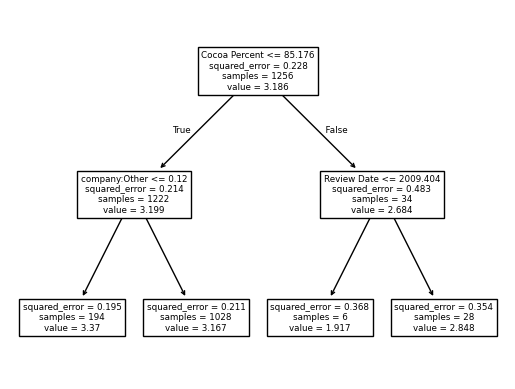

In [79]:
# Визуализируем дерево решений
# Показывает структуру модели: узлы, условия разбиения и предсказания в листьях
plot_tree(tree_search1, feature_names=features)